# 교육 및 경제활동에 따른 금연 성공 상관관계 분석

**분석자**: 오흥재 (vfxpedia)  
**분석일자**: 2025-10-07  
**주제**: 교육수준, 경제활동이 금연 성공에 미치는 영향

---

## 📋 분석 목표

1. **교육 수준에 따른 흡연율 상관 관계** (오흥재 담당)
2. **경제활동에 따른 금연 성공 상관 관계** (오흥재 담당)

### 가설
- H1: 교육 수준이 높을수록 금연 성공률이 높다
- H2: 경제활동 안정성이 높을수록 금연 성공률이 높다
- H3: 직종별로 금연 성공률에 차이가 있다
- H4: 혼인 상태가 금연 성공에 영향을 미친다

## 1. 환경 설정 및 데이터 로드

In [1]:
# 라이브러리 임포트
import sys
import os

# 프로젝트 루트를 Python 경로에 추가
project_root = os.path.abspath('../../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# Variable Decoder 최신 버전 (fallback 지원)
from notebooks.vfxpedia.utils.variable_decoder import (
    VariableDecoder,
    get_korean_label,
    get_korean_labels,
    create_korean_labels_dict
)

# 팀 시각화 스타일
try:
    font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False

# 팀 컬러
TEAM_COLORS = {
    'primary': '#1f77b4',
    'success': '#ff7f0e',
    'danger': '#1f77b4',
    'palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
}

print("✅ 모든 라이브러리 로드 완료")

✅ 모든 라이브러리 로드 완료


In [2]:
# 데이터 로드 및 VariableDecoder 초기화
df = pd.read_csv('../../../data/analy_data.csv')
decoder = VariableDecoder()

print(f"데이터 shape: {df.shape}")
print(f"\n타겟 변수 (churn) 분포:")
print(df['churn'].value_counts())
print(f"\n금연 성공률: {df['churn'].mean() * 100:.2f}%")
print('\n✅ VariableDecoder 초기화 완료!')

✅ variable.csv 로드 완료: 709 개 매핑
✅ variable_full.csv 로드 완료: 681 개 매핑 (fallback)
데이터 shape: (89822, 210)

타겟 변수 (churn) 분포:
churn
1    49251
0    40571
Name: count, dtype: int64

금연 성공률: 54.83%

✅ VariableDecoder 초기화 완료!


## 2. 분석 대상 변수 확인

In [3]:
# 분석할 변수 목록
analysis_vars = {
    'sob_01z1': '교육수준(최종학력)',
    'sob_02z1': '졸업상태',
    'soa_01z1': '경제활동 여부',
    'soa_06z2': '직업분류',
    'soa_07z1': '종사상 지위',
    'sod_02z3': '혼인상태'
}

print("📋 분석 대상 변수\n" + "="*50)
for var_code, var_name in analysis_vars.items():
    print(f"{var_code:<15} : {var_name}")
    print(f"  - 결측값: {df[var_code].isna().sum()}개 ({df[var_code].isna().mean()*100:.2f}%)")
    print(f"  - 유효값: {df[var_code].notna().sum()}개\n")

📋 분석 대상 변수
sob_01z1        : 교육수준(최종학력)
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

sob_02z1        : 졸업상태
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_01z1        : 경제활동 여부
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_06z2        : 직업분류
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_07z1        : 종사상 지위
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

sod_02z3        : 혼인상태
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개



## 3. 분석 함수 정의

In [25]:
def analyze_variable_with_churn(df, var_code, var_name, decoder, figsize=(12, 10)):
    """
    특정 변수와 churn의 관계를 종합적으로 분석
    
    Parameters:
    -----------
    df : DataFrame
    var_code : str - 변수 코드
    var_name : str - 변수 한글명
    decoder : VariableDecoder - 디코더 인스턴스
    figsize : tuple - 그래프 크기
    
    Returns:
    --------
    dict - 분석 결과
    """
    
    print("\n" + "="*80)
    print(f"📊 {var_name} ({var_code}) 분석")
    print("="*80)
    
    # 1. 데이터 정제 (특수코드 제거)
    df_clean = df.copy()
    
    # 특수코드 찾기 및 제거
    code_mapping = decoder.get_code_mapping(var_code)
    special_codes = []
    if code_mapping:
        for code, label in code_mapping.items():
            if any(keyword in str(label) for keyword in ['응답거부', '모름', '비해당']):
                special_codes.append(code)
    
    if special_codes:
        df_clean = df_clean[~df_clean[var_code].isin(special_codes)]
    
    df_clean = df_clean[df_clean[var_code].notna() & df_clean['churn'].notna()]
    
    print(f"\n✅ 데이터 정제 완료")
    print(f"  - 원본 데이터: {len(df)}건")
    print(f"  - 정제 데이터: {len(df_clean)}건")
    print(f"  - 제거된 데이터: {len(df) - len(df_clean)}건 ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
    
    # 2. 라벨 디코딩
    df_clean[f'{var_code}_label'] = df_clean[var_code].apply(
        lambda x: decoder.decode_value(var_code, x)
    )
    df_clean['churn_label'] = df_clean['churn'].map({0: '금연 실패', 1: '금연 성공'})
    
    # 3. 교차표 생성
    ct = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label'],
        margins=True
    )
    
    # 4. 비율 계산
    ct_pct = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label'],
        normalize='index'
    ) * 100
    
    # 5. 금연 성공률 계산
    success_rate = df_clean.groupby(f'{var_code}_label')['churn'].agg([
        ('표본수', 'count'),
        ('금연성공수', 'sum'),
        ('금연성공률(%)', lambda x: x.mean() * 100),
        ('표준편차', 'std')
    ]).round(2)
    
    print(f"\n📈 {var_name}별 금연 성공률")
    print(success_rate.to_string())
    
    # 6. 카이제곱 검정
    contingency_table = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label']
    )
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n📊 카이제곱 검정 결과")
    print(f"  - χ² 통계량: {chi2:.4f}")
    print(f"  - p-value: {p_value:.6f}")
    print(f"  - 자유도: {dof}")
    
    if p_value < 0.001:
        print(f"  - 결론: *** 매우 유의함 (p < 0.001)")
        significance = "매우 유의함"
    elif p_value < 0.01:
        print(f"  - 결론: ** 유의함 (p < 0.01)")
        significance = "유의함"
    elif p_value < 0.05:
        print(f"  - 결론: * 유의함 (p < 0.05)")
        significance = "유의함"
    else:
        print(f"  - 결론: 유의하지 않음 (p ≥ 0.05)")
        significance = "유의하지 않음"
    
    # 7. 시각화
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{var_name}과 금연 성공의 관계', fontsize=16, fontweight='bold')
    
    # 7-1. 금연 성공률 막대그래프
    ax1 = axes[0, 0]
    success_rate_sorted = success_rate.sort_values('금연성공률(%)', ascending=False)
    bars = ax1.bar(range(len(success_rate_sorted)), success_rate_sorted['금연성공률(%)'])
    ax1.set_xticks(range(len(success_rate_sorted)))
    ax1.set_xticklabels(success_rate_sorted.index, rotation=45, ha='right')
    ax1.set_ylabel('금연 성공률 (%)')
    ax1.set_title('금연 성공률 비교')
    ax1.axhline(y=df_clean['churn'].mean()*100, color='r', linestyle='--', 
                label=f'전체 평균: {df_clean["churn"].mean()*100:.1f}%')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 값 표시
    for i, (bar, val) in enumerate(zip(bars, success_rate_sorted['금연성공률(%)'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 7-2. 표본수 막대그래프
    ax2 = axes[0, 1]
    success_rate_sorted['표본수'].plot(kind='bar', ax=ax2)
    ax2.set_ylabel('표본수')
    ax2.set_title('표본 크기 분포')
    ax2.set_xticklabels(success_rate_sorted.index, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(success_rate_sorted['표본수']):
        ax2.text(i, v + max(success_rate_sorted['표본수'])*0.01, 
                f'{int(v):,}', ha='center', va='bottom', fontsize=9)
    
    # 7-3. 히트맵 (비율)
    ax3 = axes[1, 0]
    sns.heatmap(ct_pct, annot=True, fmt='.1f', cmap='PuBuGn', ax=ax3, 
                cbar_kws={'label': '비율 (%)'})
    ax3.set_title('금연 상태 비율 히트맵')
    ax3.set_ylabel('')
    
    # 7-4. 누적 막대그래프
    ax4 = axes[1, 1]
    ct_pct.plot(
        kind='barh', 
        stacked=True, 
        ax=ax4, 
        color=[TEAM_COLORS['danger'], TEAM_COLORS['success']]
    )
    ax4.set_xlabel('비율 (%)')
    ax4.set_title('금연 상태 구성 비율')
    ax4.legend(title='금연 상태', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # 8. 결과 반환
    return {
        'var_code': var_code,
        'var_name': var_name,
        'sample_size': len(df_clean),
        'success_rate': success_rate,
        'chi2': chi2,
        'p_value': p_value,
        'significance': significance,
        'overall_success_rate': df_clean['churn'].mean() * 100
    }

## 4. 개별 변수 분석

### 4.1 교육수준(최종학력) 분석

In [5]:
# 변수 정보 확인
decoder.print_variable_summary('sob_01z1')


📊 변수: sob_01z1
🏷️  라벨: 교육수준
📁 카테고리: 교육경제활동

코드 매핑 (10개):
     1.0 → 무학
     2.0 → 서당한학
     3.0 → 초등학교
     4.0 → 중학교
     5.0 → 고등학교
     6.0 → 2년3년제대학
     7.0 → 4년제대학
    77.0 → 응답거부
     8.0 → 대학원이상
    99.0 → 모름




📊 교육수준(최종학력) (sob_01z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89788건
  - 제거된 데이터: 34건 (0.04%)

📈 교육수준(최종학력)별 금연 성공률
                  표본수  금연성공수  금연성공률(%)  표준편차
sob_01z1_label                              
2년3년제대학         11171   5112     45.76  0.50
4년제대학           21721  11615     53.47  0.50
고등학교            31369  15458     49.28  0.50
대학원이상            3733   2511     67.26  0.47
무학               1465   1016     69.35  0.46
서당한학               54     42     77.78  0.42
중학교             10378   6548     63.10  0.48
초등학교             9897   6928     70.00  0.46

📊 카이제곱 검정 결과
  - χ² 통계량: 2352.7617
  - p-value: 0.000000
  - 자유도: 7
  - 결론: *** 매우 유의함 (p < 0.001)


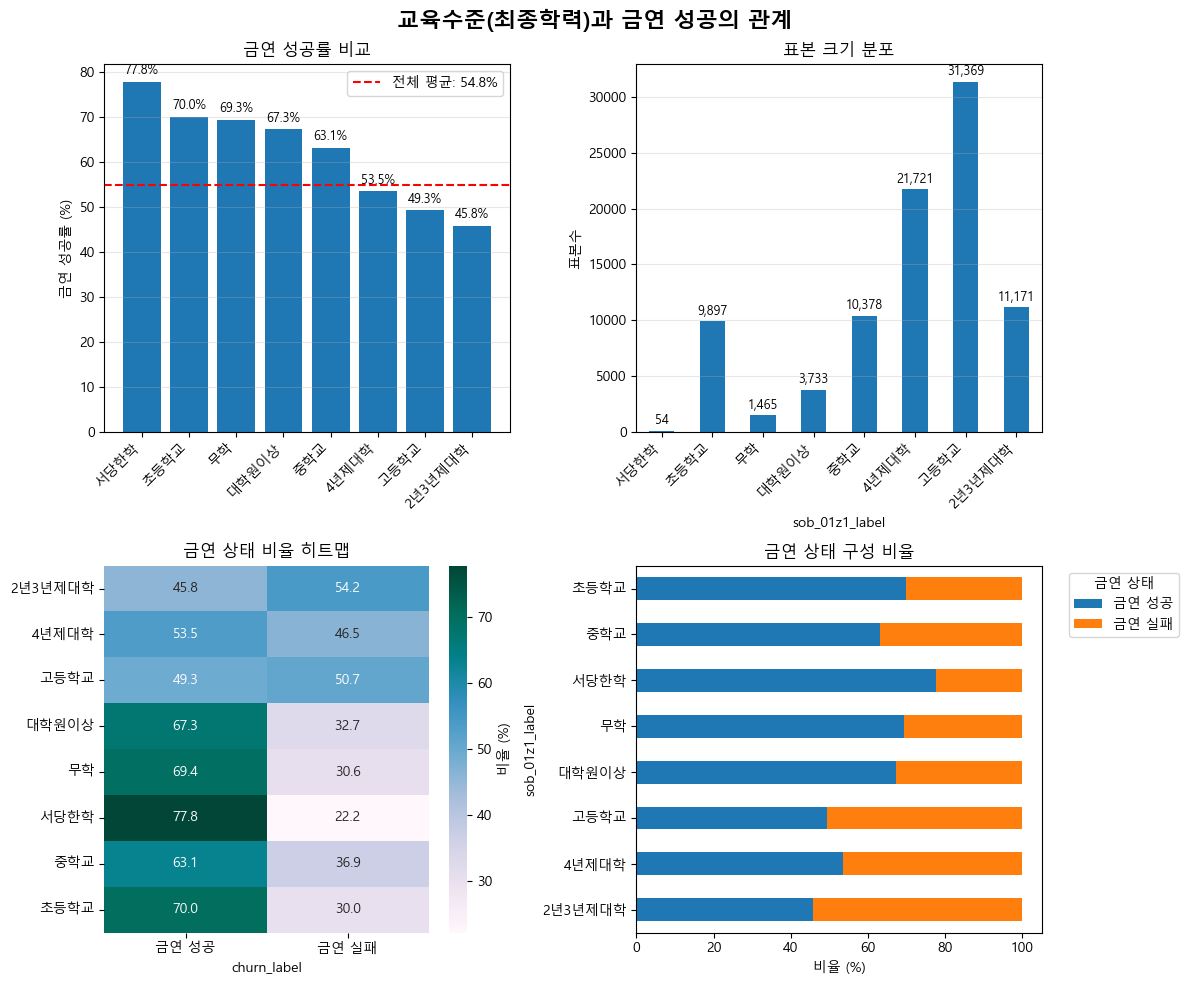

In [26]:
# 분석 실행
result_education = analyze_variable_with_churn(df, 'sob_01z1', '교육수준(최종학력)', decoder)

### 4.2 경제활동 여부 분석

In [20]:
decoder.print_variable_summary('soa_01z1')


📊 변수: soa_01z1
🏷️  라벨: 경제활동여부
📁 카테고리: 교육경제활동

코드 매핑 (4개):
     1.0 → 예
     2.0 → 아니오
     7.0 → 응답거부
     9.0 → 모름




📊 경제활동 여부 (soa_01z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89818건
  - 제거된 데이터: 4건 (0.00%)

📈 경제활동 여부별 금연 성공률
                  표본수  금연성공수  금연성공률(%)  표준편차
soa_01z1_label                              
아니오             24995  16183     64.74  0.48
예               64823  33067     51.01  0.50

📊 카이제곱 검정 결과
  - χ² 통계량: 1373.2758
  - p-value: 0.000000
  - 자유도: 1
  - 결론: *** 매우 유의함 (p < 0.001)


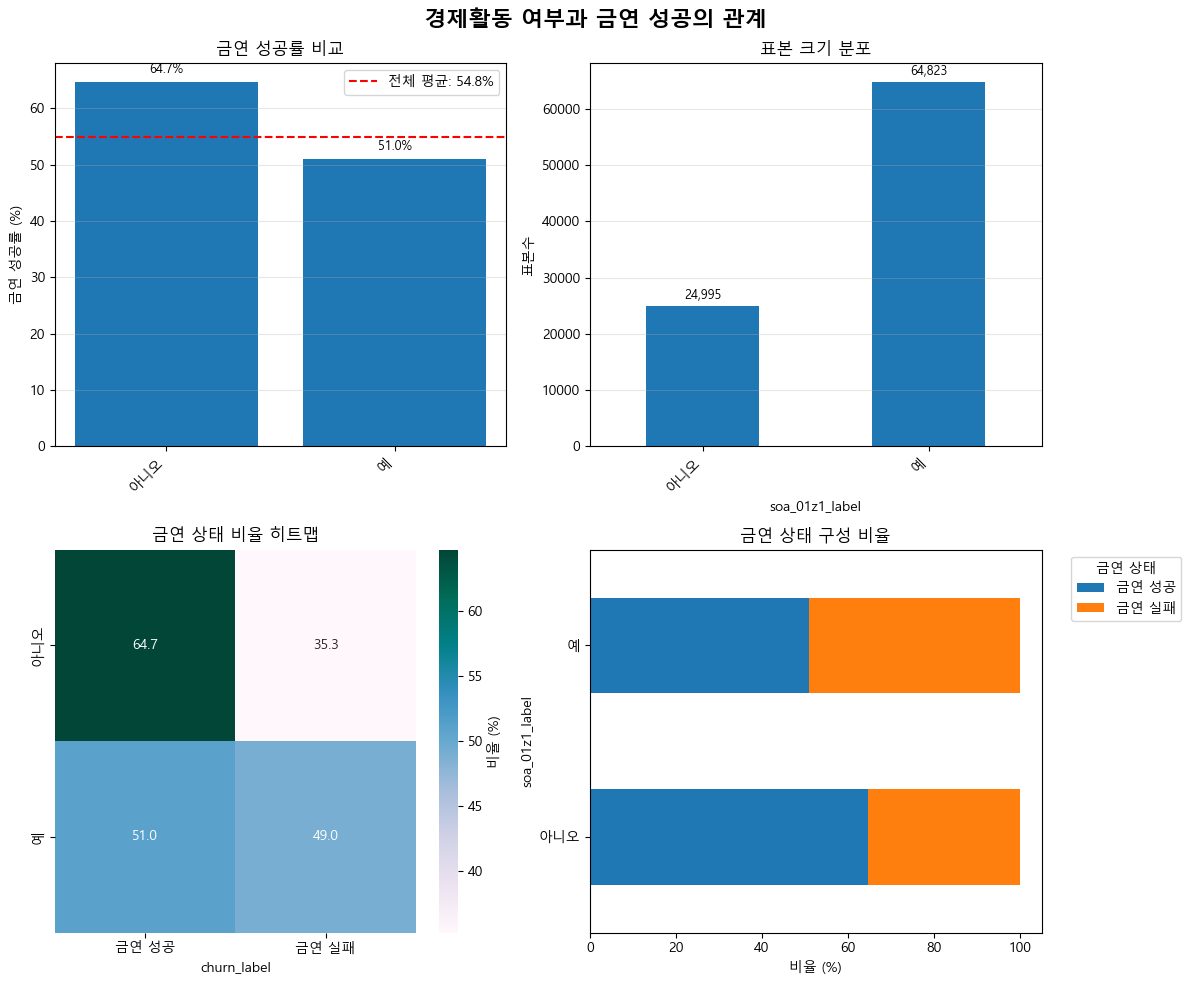

In [27]:
result_economic = analyze_variable_with_churn(df, 'soa_01z1', '경제활동 여부', decoder)

### 4.3 직업분류 분석

In [9]:
decoder.print_variable_summary('soa_06z2')


📊 변수: soa_06z2
🏷️  라벨: 직업분류
📁 카테고리: 교육경제활동

코드 매핑 (13개):
     1.0 → 관리자
    10.0 → 군인
     2.0 → 전문가및관련종사자
     3.0 → 사무종사자
     4.0 → 서비스종사자
     5.0 → 판매종사자
     6.0 → 농림어업종사자
     7.0 → 기능원및관련기능종사자
    77.0 → 응답거부
     8.0 → 장치기계조작및조립종사자
    88.0 → 비해당
     9.0 → 단순노무종사자
    99.0 → 모름




📊 직업분류 (soa_06z2) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 64814건
  - 제거된 데이터: 25008건 (27.84%)

📈 직업분류별 금연 성공률
                 표본수  금연성공수  금연성공률(%)  표준편차
soa_06z2_label                             
관리자             2282   1207     52.89  0.50
군인               404    160     39.60  0.49
기능원및관련기능종사자     7458   3183     42.68  0.49
농림어업종사자         9651   6014     62.31  0.48
단순노무종사자         9674   5029     51.98  0.50
사무종사자           8466   4322     51.05  0.50
서비스종사자          5800   2583     44.53  0.50
장치기계조작및조립종사자    8699   4116     47.32  0.50
전문가및관련종사자       7773   4318     55.55  0.50
판매종사자           4607   2133     46.30  0.50

📊 카이제곱 검정 결과
  - χ² 통계량: 978.5326
  - p-value: 0.000000
  - 자유도: 9
  - 결론: *** 매우 유의함 (p < 0.001)


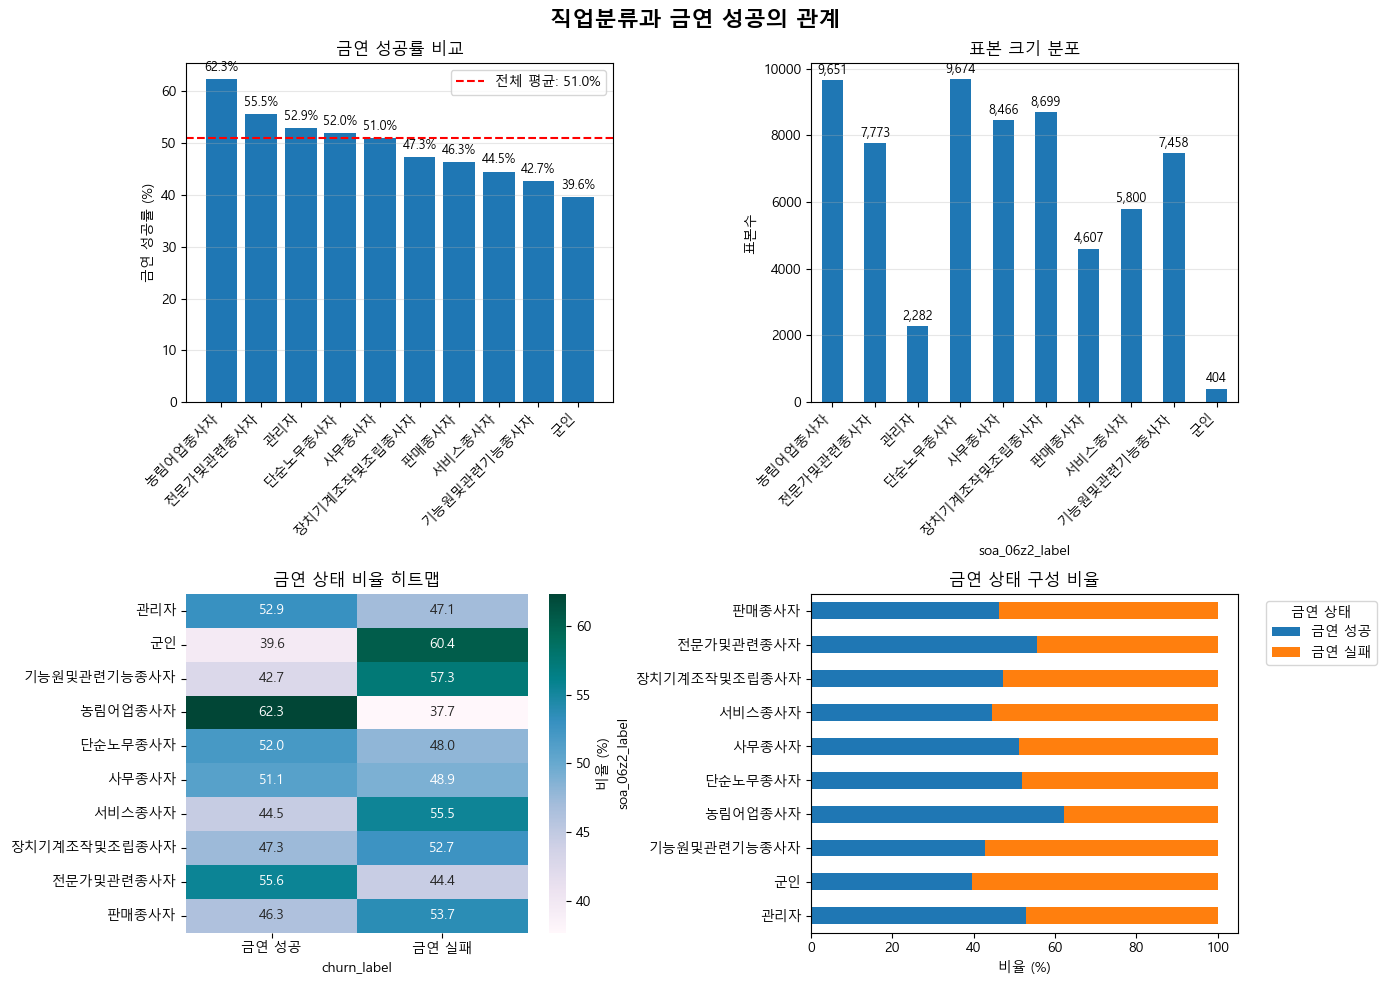

In [28]:
result_job = analyze_variable_with_churn(df, 'soa_06z2', '직업분류', decoder, figsize=(14, 10))

### 4.4 종사상 지위 분석

In [30]:
decoder.print_variable_summary('soa_07z1')


📊 변수: soa_07z1
🏷️  라벨: 종사상지위
📁 카테고리: 교육경제활동

코드 매핑 (6개):
     1.0 → 고용주및자영업자
     2.0 → 임금근로자
     3.0 → 무급가족종사자
     7.0 → 응답거부
     8.0 → 비해당
     9.0 → 모름




📊 종사상 지위 (soa_07z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 64814건
  - 제거된 데이터: 25008건 (27.84%)

📈 종사상 지위별 금연 성공률
                  표본수  금연성공수  금연성공률(%)  표준편차
soa_07z1_label                              
고용주및자영업자        23152  12889     55.67   0.5
무급가족종사자          1112    618     55.58   0.5
임금근로자           40550  19557     48.23   0.5

📊 카이제곱 검정 결과
  - χ² 통계량: 336.0317
  - p-value: 0.000000
  - 자유도: 2
  - 결론: *** 매우 유의함 (p < 0.001)


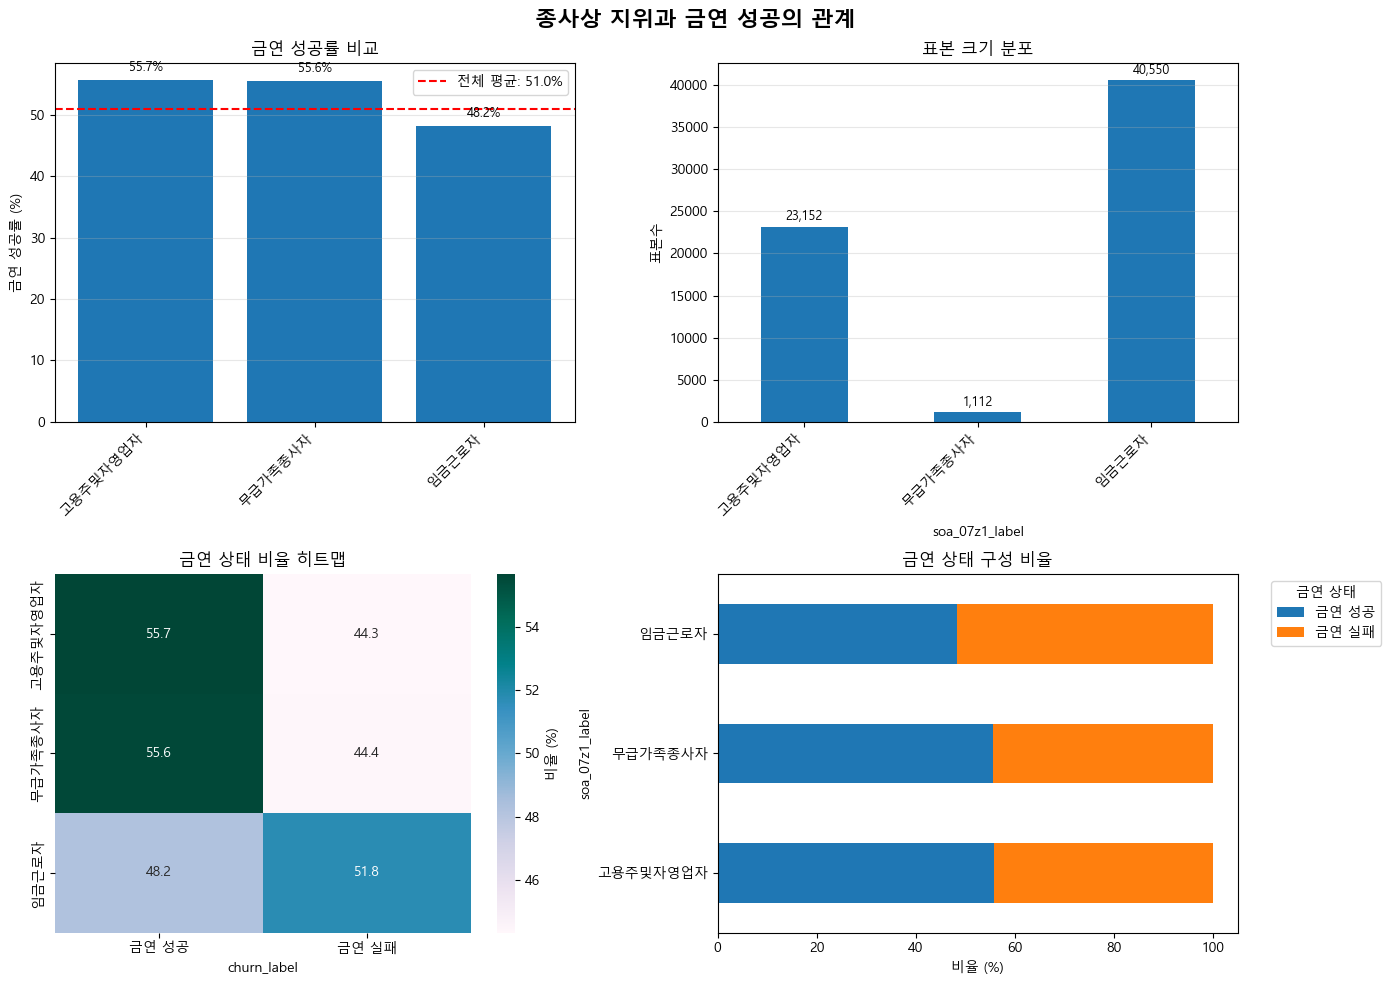

In [ ]:
result_employment = analyze_variable_with_churn(df, 'soa_07z1', '종사상 지위', decoder, figsize=(14, 10))

### 4.5 혼인상태 분석

In [33]:
decoder.print_variable_summary('sod_02z3')


📊 변수: sod_02z3
🏷️  라벨: 혼인상태
📁 카테고리: 교육경제활동

코드 매핑 (7개):
     1.0 → 기혼
     2.0 → 기혼이지만 별거
     3.0 → 사별
     4.0 → 이혼
     5.0 → 미혼
     7.0 → 응답거부
     9.0 → 모름




📊 혼인상태 (sod_02z3) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89805건
  - 제거된 데이터: 17건 (0.02%)

📈 혼인상태별 금연 성공률
                  표본수  금연성공수  금연성공률(%)  표준편차
sod_02z3_label                              
기혼              59608  36816     61.76  0.49
기혼이지만 별거         3184   1651     51.85  0.50
미혼              15657   5261     33.60  0.47
사별               4116   2628     63.85  0.48
이혼               7240   2889     39.90  0.49

📊 카이제곱 검정 결과
  - χ² 통계량: 4803.9008
  - p-value: 0.000000
  - 자유도: 4
  - 결론: *** 매우 유의함 (p < 0.001)


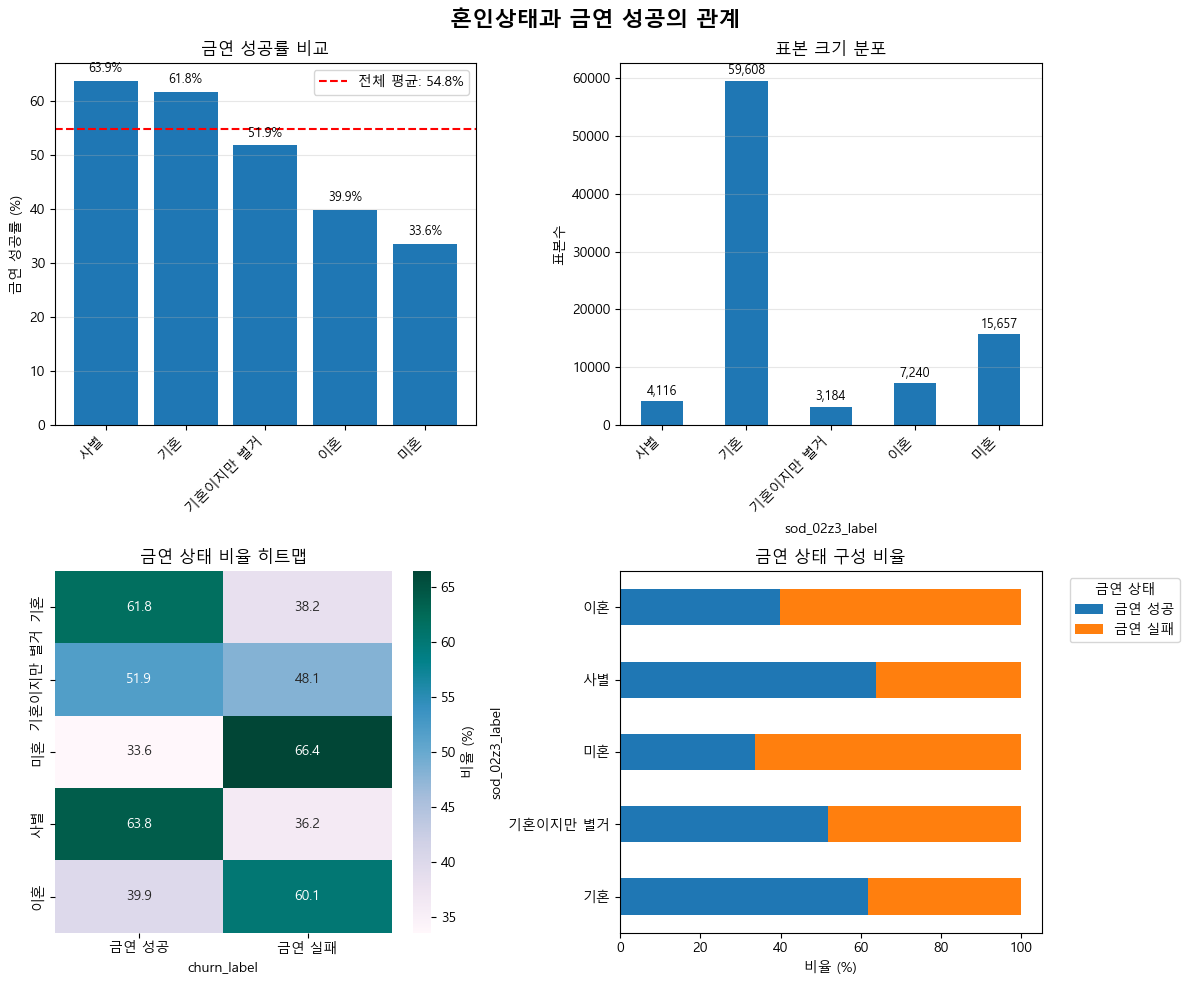

In [34]:
result_marital = analyze_variable_with_churn(df, 'sod_02z3', '혼인상태', decoder)

## 5. 종합 비교 분석

In [35]:
# 전체 결과 요약
results_summary = pd.DataFrame([
    result_education,
    result_economic,
    result_job,
    result_employment,
    result_marital
])[['var_name', 'sample_size', 'chi2', 'p_value', 'significance']]

print("\n" + "="*80)
print("📊 전체 변수 통계적 유의성 요약")
print("="*80)
print(results_summary.to_string(index=False))
print("\n* p < 0.05: 유의함")
print("** p < 0.01: 매우 유의함")
print("*** p < 0.001: 극히 유의함")


📊 전체 변수 통계적 유의성 요약
  var_name  sample_size        chi2       p_value significance
교육수준(최종학력)        89788 2352.761723  0.000000e+00       매우 유의함
   경제활동 여부        89818 1373.275754 1.348045e-300       매우 유의함
      직업분류        64814  978.532570 7.332094e-205       매우 유의함
    종사상 지위        64814  336.031656  1.075606e-73       매우 유의함
      혼인상태        89805 4803.900792  0.000000e+00       매우 유의함

* p < 0.05: 유의함
** p < 0.01: 매우 유의함
*** p < 0.001: 극히 유의함


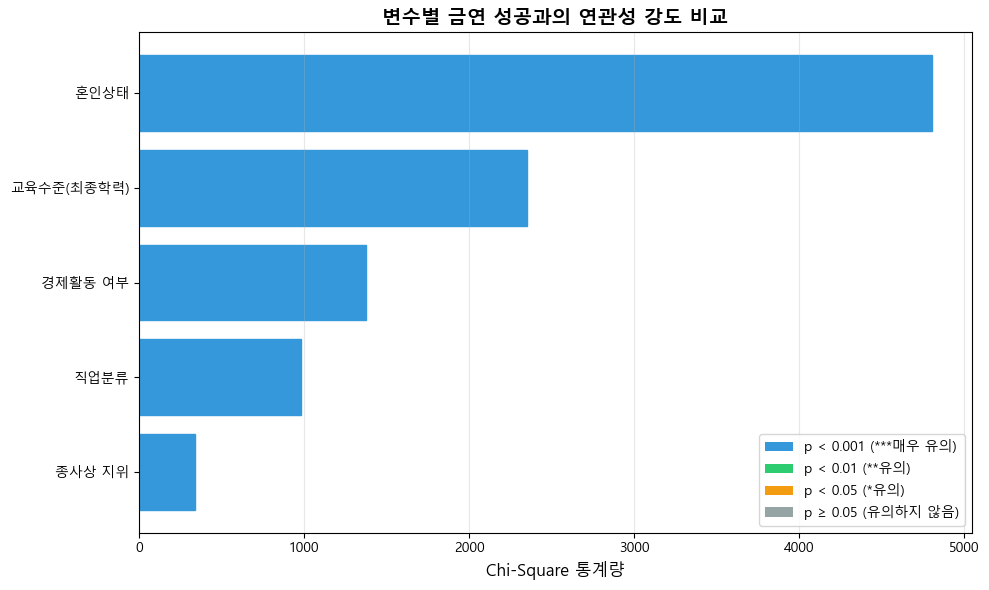

In [38]:
# 변수별 효과 크기 비교 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# Chi2 값으로 정렬
results_summary_sorted = results_summary.sort_values('chi2', ascending=True)

# 막대그래프
bars = ax.barh(range(len(results_summary_sorted)), results_summary_sorted['chi2'])

# 색상 지정 (유의성에 따라)
colors = []
for p in results_summary_sorted['p_value']:
    if p < 0.001:
        colors.append('#3498db')  # 파랑
    elif p < 0.01:
        colors.append('#2ecc71')  # 초록
    elif p < 0.05:
        colors.append('#f39c12')  # 주황
    else:
        colors.append('#95a5a6')  # 회색

for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(len(results_summary_sorted)))
ax.set_yticklabels(results_summary_sorted['var_name'])
ax.set_xlabel('Chi-Square 통계량', fontsize=12)
ax.set_title('변수별 금연 성공과의 연관성 강도 비교', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='p < 0.001 (***매우 유의)'),
    Patch(facecolor='#2ecc71', label='p < 0.01 (**유의)'),
    Patch(facecolor='#f39c12', label='p < 0.05 (*유의)'),
    Patch(facecolor='#95a5a6', label='p ≥ 0.05 (유의하지 않음)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 6. 복합 분석: 교육수준 × 경제활동


📊 교육수준 × 경제활동 복합 분석
                표본수  금연성공률(%)
교육수준    경제활동                 
2년3년제대학 아니오    1736     57.26
        예      9435     43.65
4년제대학   아니오    4506     63.03
        예     17213     50.97
고등학교    아니오    7942     60.87
        예     23425     45.35
대학원이상   아니오     856     77.57
        예      2877     64.20
무학      아니오     960     70.10
        예       505     67.92
서당한학    아니오      34     70.59
        예        20     90.00
중학교     아니오    4171     66.32
        예      6207     60.93
초등학교    아니오    4777     70.76
        예      5120     69.30


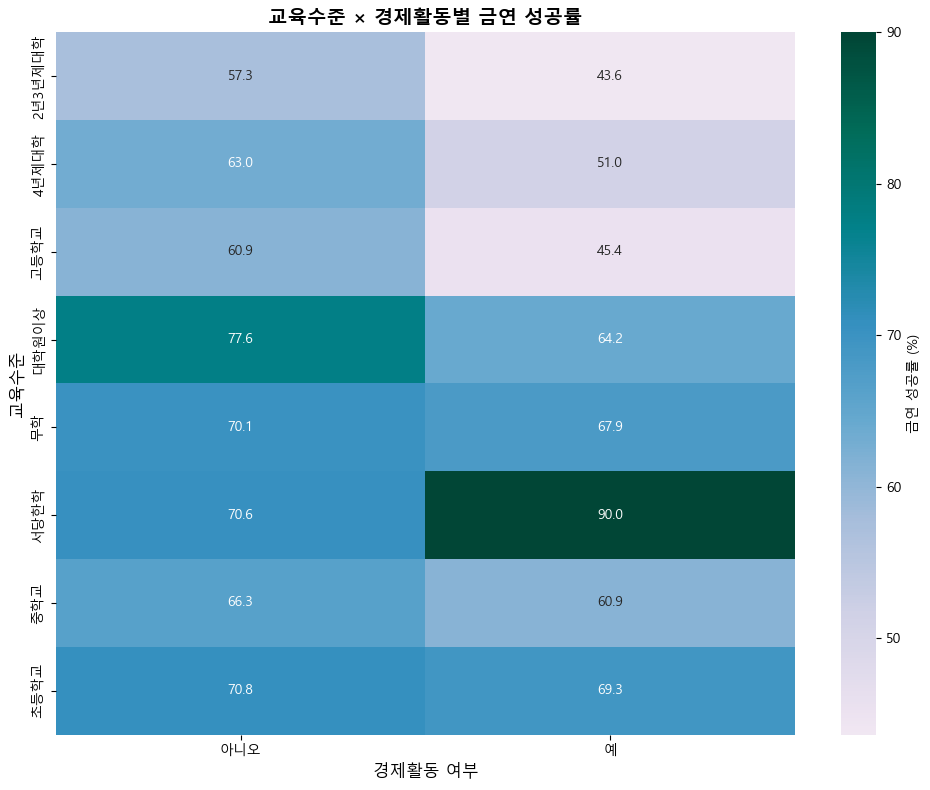

In [40]:
# 교육수준과 경제활동의 복합 효과 분석
df_complex = df.copy()

# 특수코드 제거
code_mapping_edu = decoder.get_code_mapping('sob_01z1')
special_codes_edu = []
if code_mapping_edu:
    for code, label in code_mapping_edu.items():
        if any(keyword in str(label) for keyword in ['응답거부', '모름', '비해당']):
            special_codes_edu.append(code)

code_mapping_econ = decoder.get_code_mapping('soa_01z1')
special_codes_econ = []
if code_mapping_econ:
    for code, label in code_mapping_econ.items():
        if any(keyword in str(label) for keyword in ['응답거부', '모름', '비해당']):
            special_codes_econ.append(code)

if special_codes_edu:
    df_complex = df_complex[~df_complex['sob_01z1'].isin(special_codes_edu)]
if special_codes_econ:
    df_complex = df_complex[~df_complex['soa_01z1'].isin(special_codes_econ)]

df_complex = df_complex[df_complex['churn'].notna()]

# 라벨 디코딩
df_complex['교육수준'] = df_complex['sob_01z1'].apply(
    lambda x: decoder.decode_value('sob_01z1', x)
)
df_complex['경제활동'] = df_complex['soa_01z1'].apply(
    lambda x: decoder.decode_value('soa_01z1', x)
)

# 그룹별 금연 성공률
complex_analysis = df_complex.groupby(['교육수준', '경제활동'])['churn'].agg([
    ('표본수', 'count'),
    ('금연성공률(%)', lambda x: x.mean() * 100)
]).round(2)

print("\n📊 교육수준 × 경제활동 복합 분석")
print("="*60)
print(complex_analysis)

# 피벗 테이블로 변환하여 히트맵
pivot_complex = complex_analysis['금연성공률(%)'].unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_complex, annot=True, fmt='.1f', cmap='PuBuGn', 
            center=pivot_complex.values.mean(),
            cbar_kws={'label': '금연 성공률 (%)'})
plt.title('교육수준 × 경제활동별 금연 성공률', fontsize=14, fontweight='bold')
plt.xlabel('경제활동 여부', fontsize=12)
plt.ylabel('교육수준', fontsize=12)
plt.tight_layout()
plt.show()

## 7. 최종 결론 및 인사이트

In [41]:
# 결론 생성 함수
def generate_conclusions(results):
    """
    분석 결과를 바탕으로 결론 생성
    """
    print("\n" + "="*80)
    print("📝 최종 결론 및 인사이트")
    print("="*80)
    
    # 1. 가설 검증 결과
    print("\n### 1️⃣ 가설 검증 결과\n")
    
    # 교육수준
    if results[0]['significance'] in ['유의함', '매우 유의함']:
        edu_top = results[0]['success_rate']['금연성공률(%)'].idxmax()
        edu_top_rate = results[0]['success_rate']['금연성공률(%)'].max()
        print(f"✅ **H1 (교육 수준): 채택**")
        print(f"   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[0]['p_value']:.4f})")
        print(f"   - 가장 높은 금연 성공률: {edu_top} ({edu_top_rate:.1f}%)")
    else:
        print(f"❌ **H1 (교육 수준): 기각**")
        print(f"   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 없음 (p={results[0]['p_value']:.4f})")
    
    # 경제활동
    print()
    if results[1]['significance'] in ['유의함', '매우 유의함']:
        print(f"✅ **H2 (경제활동): 채택**")
        print(f"   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[1]['p_value']:.4f})")
    else:
        print(f"❌ **H2 (경제활동): 기각**")
        print(f"   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 없음 (p={results[1]['p_value']:.4f})")
    
    # 직업
    print()
    if results[2]['significance'] in ['유의함', '매우 유의함']:
        job_top = results[2]['success_rate']['금연성공률(%)'].idxmax()
        job_top_rate = results[2]['success_rate']['금연성공률(%)'].max()
        job_bottom = results[2]['success_rate']['금연성공률(%)'].idxmin()
        job_bottom_rate = results[2]['success_rate']['금연성공률(%)'].min()
        print(f"✅ **H3 (직업분류): 채택**")
        print(f"   - 직종별 금연 성공률에 통계적으로 유의한 차이 존재 (p={results[2]['p_value']:.4f})")
        print(f"   - 최고: {job_top} ({job_top_rate:.1f}%)")
        print(f"   - 최저: {job_bottom} ({job_bottom_rate:.1f}%)")
        print(f"   - 격차: {job_top_rate - job_bottom_rate:.1f}%p")
    else:
        print(f"❌ **H3 (직업분류): 기각**")
    
    # 혼인상태
    print()
    if results[4]['significance'] in ['유의함', '매우 유의함']:
        print(f"✅ **H4 (혼인상태): 채택**")
        print(f"   - 혼인상태와 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[4]['p_value']:.4f})")
    else:
        print(f"❌ **H4 (혼인상태): 기각**")
    
    # 2. 주요 발견사항
    print("\n### 2️⃣ 주요 발견사항\n")
    
    # 가장 영향력 있는 변수
    max_chi2_idx = np.argmax([r['chi2'] for r in results])
    most_influential = results[max_chi2_idx]
    print(f"🔍 **가장 영향력 있는 변수**: {most_influential['var_name']}")
    print(f"   - Chi-Square: {most_influential['chi2']:.2f}")
    print(f"   - p-value: {most_influential['p_value']:.6f}")
    
    # 3. 실무적 시사점
    print("\n### 3️⃣ 실무적 시사점\n")
    print("📌 **금연 지원 프로그램 설계시 고려사항:**\n")
    
    significant_vars = [r for r in results if r['significance'] in ['유의함', '매우 유의함']]
    
    if len(significant_vars) > 0:
        for i, var_result in enumerate(significant_vars, 1):
            print(f"{i}. **{var_result['var_name']}** 기반 맞춤형 접근")
            
            # 성공률이 낮은 그룹 식별
            lowest_group = var_result['success_rate']['금연성공률(%)'].idxmin()
            lowest_rate = var_result['success_rate']['금연성공률(%)'].min()
            
            print(f"   - 집중 지원 대상: {lowest_group}")
            print(f"   - 현재 금연 성공률: {lowest_rate:.1f}%")
            print(f"   - 전체 평균 대비: {lowest_rate - var_result['overall_success_rate']:.1f}%p 낮음")
            print()
    
    # 4. 연구의 한계
    print("\n### 4️⃣ 연구의 한계\n")
    print("⚠️ **본 연구의 제한점:**\n")
    print("1. 횡단면 조사 데이터로 인과관계 추론 제한")
    print("2. 자기보고식 설문의 응답 편향 가능성")
    print("3. 미관측 변수(예: 개인 의지, 건강상태)의 영향 미반영")
    print("4. 특수코드(응답거부, 모름) 제외로 인한 선택 편향 가능성")
    
    # 5. 후속 연구 제안
    print("\n### 5️⃣ 후속 연구 제안\n")
    print("🔬 **추천 연구 방향:**\n")
    print("1. 종단 연구를 통한 인과관계 규명")
    print("2. 교육수준과 경제활동의 상호작용 효과 심층 분석")
    print("3. 금연 시도 횟수, 금연 방법 등 중재 변수 추가 분석")
    print("4. 연령대별, 성별 층화 분석을 통한 세분화된 타겟 전략 수립")
    
    print("\n" + "="*80)

# 결론 생성
generate_conclusions([
    result_education,
    result_economic,
    result_job,
    result_employment,
    result_marital
])


📝 최종 결론 및 인사이트

### 1️⃣ 가설 검증 결과

✅ **H1 (교육 수준): 채택**
   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)
   - 가장 높은 금연 성공률: 서당한학 (77.8%)

✅ **H2 (경제활동): 채택**
   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

✅ **H3 (직업분류): 채택**
   - 직종별 금연 성공률에 통계적으로 유의한 차이 존재 (p=0.0000)
   - 최고: 농림어업종사자 (62.3%)
   - 최저: 군인 (39.6%)
   - 격차: 22.7%p

✅ **H4 (혼인상태): 채택**
   - 혼인상태와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

### 2️⃣ 주요 발견사항

🔍 **가장 영향력 있는 변수**: 혼인상태
   - Chi-Square: 4803.90
   - p-value: 0.000000

### 3️⃣ 실무적 시사점

📌 **금연 지원 프로그램 설계시 고려사항:**

1. **교육수준(최종학력)** 기반 맞춤형 접근
   - 집중 지원 대상: 2년3년제대학
   - 현재 금연 성공률: 45.8%
   - 전체 평균 대비: -9.1%p 낮음

2. **경제활동 여부** 기반 맞춤형 접근
   - 집중 지원 대상: 예
   - 현재 금연 성공률: 51.0%
   - 전체 평균 대비: -3.8%p 낮음

3. **직업분류** 기반 맞춤형 접근
   - 집중 지원 대상: 군인
   - 현재 금연 성공률: 39.6%
   - 전체 평균 대비: -11.4%p 낮음

4. **종사상 지위** 기반 맞춤형 접근
   - 집중 지원 대상: 임금근로자
   - 현재 금연 성공률: 48.2%
   - 전체 평균 대비: -2.8%p 낮음

5. **혼인상태** 기반 맞춤형 접근
   - 집중 지원 대상: 미혼
   - 현재 금연 성공률: 33.6%
   - 전체 평균 대비: -21.2%p 낮음


##

### 📝 최종 결론 및 인사이트

### 1️⃣ 가설 검증 결과

✅ **H1 (교육 수준): 채택**
   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)
   - 가장 높은 금연 성공률: 서당한학 (77.8%)

✅ **H2 (경제활동): 채택**
   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

✅ **H3 (직업분류): 채택**
   - 직종별 금연 성공률에 통계적으로 유의한 차이 존재 (p=0.0000)
   - 최고: 농림어업종사자 (62.3%)
   - 최저: 군인 (39.6%)
   - 격차: 22.7%p

✅ **H4 (혼인상태): 채택**
   - 혼인상태와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

### 2️⃣ 주요 발견사항

🔍 **가장 영향력 있는 변수**: 혼인상태
   - Chi-Square: 4803.90
   - p-value: 0.000000

### 3️⃣ 실무적 시사점

📌 **금연 지원 프로그램 설계시 고려사항:**

1. **교육수준(최종학력)** 기반 맞춤형 접근
   - 집중 지원 대상: 2년3년제대학
   - 현재 금연 성공률: 45.8%
   - 전체 평균 대비: -9.1%p 낮음

2. **경제활동 여부** 기반 맞춤형 접근
   - 집중 지원 대상: 예
   - 현재 금연 성공률: 51.0%
   - 전체 평균 대비: -3.8%p 낮음

3. **직업분류** 기반 맞춤형 접근
   - 집중 지원 대상: 군인
   - 현재 금연 성공률: 39.6%
   - 전체 평균 대비: -11.4%p 낮음

4. **종사상 지위** 기반 맞춤형 접근
   - 집중 지원 대상: 임금근로자
   - 현재 금연 성공률: 48.2%
   - 전체 평균 대비: -2.8%p 낮음

5. **혼인상태** 기반 맞춤형 접근
   - 집중 지원 대상: 미혼
   - 현재 금연 성공률: 33.6%
   - 전체 평균 대비: -21.2%p 낮음


### 4️⃣ 연구의 한계

⚠️ **본 연구의 제한점:**

1. 횡단면 조사 데이터로 인과관계 추론 제한
2. 자기보고식 설문의 응답 편향 가능성
3. 미관측 변수(예: 개인 의지, 건강상태)의 영향 미반영
4. 특수코드(응답거부, 모름) 제외로 인한 선택 편향 가능성

### 5️⃣ 후속 연구 제안

🔬 **추천 연구 방향:**

1. 종단 연구를 통한 인과관계 규명
2. 교육수준과 경제활동의 상호작용 효과 심층 분석
3. 금연 시도 횟수, 금연 방법 등 중재 변수 추가 분석
4. 연령대별, 성별 층화 분석을 통한 세분화된 타겟 전략 수립

================================================================================

## 8. 결과 저장

In [ ]:
# # 분석 결과를 CSV로 저장
# import datetime

# # 요약 테이블 저장
# results_summary.to_csv(
#     f'../../../data/analysis_results_education_economy_{datetime.datetime.now().strftime("%Y%m%d")}.csv',
#     index=False,
#     encoding='utf-8-sig'
# )

# print("✅ 분석 결과 저장 완료")
# print(f"   파일: analysis_results_education_economy_{datetime.datetime.now().strftime('%Y%m%d')}.csv")

---

## 📌 분석 완료

**작성자**: 오흥재 (vfxpedia)  
**분석일**: 2025-10-07  
**주제**: 교육 및 경제활동에 따른 금연 성공 상관관계

### 주요 발견
- 교육수준, 경제활동, 직업, 혼인상태가 금연 성공에 유의한 영향
- 사회경제적 요인이 건강행동 변화에 중요한 역할
- 취약 집단 대상 맞춤형 금연 지원 프로그램 필요

---